In [1]:
import tensorflow as tf
# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os
from nltk import tokenize

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding, RepeatVector, Permute, Multiply, Lambda, BatchNormalization, LeakyReLU
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, merge, Dropout, LSTM, CuDNNLSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model
from keras.callbacks import EarlyStopping, LearningRateScheduler, Callback, ModelCheckpoint

from keras.optimizers import Adam, Adadelta, SGD


from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

from tqdm import tqdm
import math
from matplotlib import pyplot as plt
import seaborn as sn
from colored import fg, bg, attr

In [3]:
class AttentionLayer(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """
    def __init__(self, **kwargs):
        self.init = initializers.get('glorot_uniform')
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer=self.init,
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(input_shape[-1], ),
                                 initializer=self.init,
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(input_shape[-1], 1),
                                 initializer=self.init,
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
    
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        
        # RNN 구조를 거쳐서 나온 hidden states (x)에 single layer perceptron (tanh activation)
        # 적용하여 나온 벡터가 uit 
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        
        # uit와 uw (혹은 us) 간의 similarity를 attention으로 사용
        # softmax를 통해 attention 값을 확률 분포로 만듬
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])

In [4]:
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 40

# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [5]:
lstm_dim = 100

input_data = Input(shape=(40,1))
bilstm = Bidirectional(LSTM(lstm_dim, return_sequences=True))(input_data)  # lstm입력은 (N, X, Y) 3차원이어여한다
# bilstm_output = Dense(1)(bilstm)

attention_layer = AttentionLayer()(bilstm)
print(attention_layer)

repeated_word_attention = RepeatVector(lstm_dim * 2)(attention_layer)
repeated_word_attention = Permute([2, 1])(repeated_word_attention)
sentence_representation = Multiply()([bilstm, repeated_word_attention])
sentence_representation = Lambda(lambda x: K.sum(x, axis=1))(sentence_representation)

bilstm_output = Dense(1)(sentence_representation)

model = Model(inputs=[input_data],
            outputs=[bilstm_output])
# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

hist = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Tensor("attention_layer_1/Softmax:0", shape=(?, 40), dtype=float32)
Train on 760 samples, validate on 360 samples
Epoch 1/10
760/760 [==============================] - 3s 3ms/step - loss: 0.1578 - val_loss: 0.1205
Epoch 2/10
760/760 [==============================] - 1s 2ms/step - loss: 0.0765 - val_loss: 0.0379
Epoch 3/10
760/760 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0039
Epoch 4/10
760/760 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 5/10
760/760 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 8.9217e-04
Epoch 6/10
760/760 [==============================] - 1s 2ms/step - loss: 5.8507e-04 - val_loss: 3.0191e-04
Epoch 7/10
760/760 [==============================] - 1s 2ms/step - loss: 2.4331e-04 - val_loss: 1.5164e-04
Epoch 8/10
760/760 [==============================] - 1s 2ms/step - loss: 1.1803e-04 - val_loss: 9.2148e-05
Epoch 9/10
760/760 [==============================] - 1s 2

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 1)        0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 40, 200)      81600       input_1[0][0]                    
__________________________________________________________________________________________________
attention_layer_1 (AttentionLay (None, 40)           40400       bidirectional_1[0][0]            
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 200, 40)      0           attention_layer_1[0][0]          
__________________________________________________________________________________________________
permute_1 

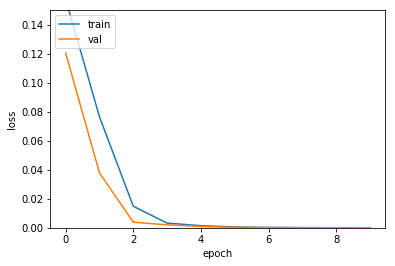

Train Score:  2.3023654495390426e-05
Validataion Score:  2.205579783347073e-05
Test Score:  2.205579783347073e-05


In [7]:
# 5. 학습과정 살펴보기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

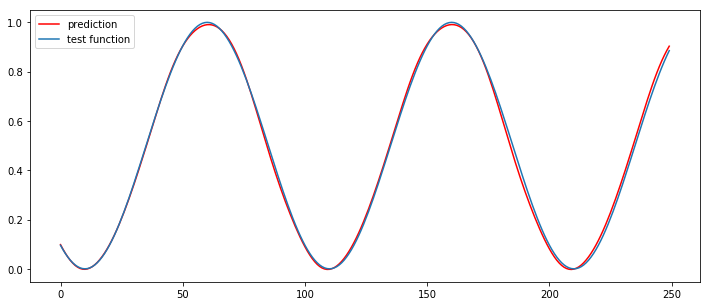

In [8]:
# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

# Attention visualize

In [9]:
# Attention check
# 위의 attention layer 부분을 output으로
attention_extractor = Model(inputs=[input_data],
                             outputs=[attention_layer])  
# (N, 40)
attention_expamle = attention_extractor.predict(x_test)

[0.00182286 0.00112382 0.00076406 0.00056554 0.00044962 0.00037927
 0.00033592 0.00030973 0.00029533 0.00028971 0.0002913  0.00029941
 0.00031407 0.0003359  0.00036617 0.00040695 0.00046138 0.00053407
 0.00063179 0.00076448 0.0009467  0.00119982 0.00155507 0.00205775
 0.00277275 0.00379142 0.00523963 0.00728644 0.0101529  0.01411996
 0.01953509 0.02681706 0.03645856 0.04902631 0.06515791 0.08555304
 0.11095696 0.14213262 0.17981932 0.22467934]


<BarContainer object of 40 artists>

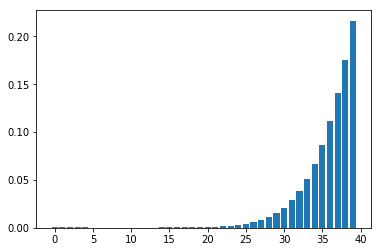

In [10]:
print(attention_expamle[0])

plt.bar(np.arange(attention_expamle.shape[1]), attention_expamle[2])